# Loading libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
from lmfit.printfuncs import *
from scipy.optimize import least_squares

# Load data

NanoDSF data for experimental set 2, 3 and 4:

In [2]:
mutants=['A3G','Y6A','Y8A','L11V','L11A','V32A','L40V','T62S','T63S','V74A','WT3_','WT2_','WT4.1_','WT4.2_']

den_s=16            #Number of samples in denaturation series

min_d=0               # min concentration of denaturant in M
max_d=6.4             # max concentration of denaturant in M

df_panta= pd.read_excel('NanoDSF_summary.xlsx') #Load data from summarised nanoDSF measurements


#Create sample name calls
samples=[]
for i in mutants:
    for j in range(den_s):
        samples.append(i+str(j+1))
        

#Calculate average fluoresence ratio from all measurements. 
data_avg = []
for i in samples:
    data_avg.append(np.nanmean(df_panta.loc[:,i]))
    

#Normalize data. These are stored as nested lists organised in the sequence as the list 'mutants':
data_norm = []
temp_list = []
for j, i in enumerate(data_avg):
    lower = math.floor(j/den_s)*den_s
    upper = lower + den_s
    temp_list.append((i-data_avg[lower])/(max(data_avg[lower:upper])-data_avg[lower]))
    if len(temp_list) == den_s:
        data_norm.append(temp_list)
        temp_list = []

Platereader data for experimental set 1:

In [3]:
#Put all datafiles here:
raw = ['i29a_i53a.csv','i82a_i22a.csv','wt_i77a.csv']

den_c_x = [10,10,6]  #Number of blank wells in each measurement
den_s1 = 24          #Number of samples in denaturation series for I22A, I29A and I53A
den_s2 = 26          #Number of samples in denaturation series for I77A, I82A and WT
wl=[310,340]         #Measured wavelengths
wl[0] = wl[0]-300    #Wavelength indexes are found
wl[1] = wl[1]-300    #Wavelenght indexes are found
w = 3                #Measurement window to each side - 307-313 and 337-343

#Blanking of data:
blanked = []
for i in raw:
    df = pd.read_csv(i)                         #Load data
    den_c = den_c_x[raw.index(i)]               #Call the number of blank wells
    df1=df.iloc[:,1:den_c].mean(axis=1)         #Calculate average of blank wells    
    data=df.iloc[:,den_c+1:]                    #Select data columns
    temp_list = []
    for iy in range(len(data.columns)):         #Subtract blank values
        temp_list.append(data.iloc[:,iy]-df1)
    DF = pd.DataFrame(temp_list).transpose()
    blanked.append(DF)                          #Store data in list

    
#Calculate the 340/310 ratio and store in nested list, such that data is ordered: I22A, I29A, I53A, I77A, I82A and WT
data_ratio = []
ratio=[blanked[1].iloc[(wl[1]-w):(wl[1]+w),j+den_s2].sum()/blanked[1].iloc[(wl[0]-w):(wl[0]+w),j+den_s2].sum() for j in range(den_s1)]
data_ratio.append(ratio)
ratio=[blanked[0].iloc[(wl[1]-w):(wl[1]+w),j].sum()/blanked[0].iloc[(wl[0]-w):(wl[0]+w),j].sum() for j in range(den_s1)]
data_ratio.append(ratio)
ratio=[blanked[0].iloc[(wl[1]-w):(wl[1]+w),j+den_s1].sum()/blanked[0].iloc[(wl[0]-w):(wl[0]+w),j+den_s1].sum() for j in range(den_s1)]
data_ratio.append(ratio)
ratio=[blanked[2].iloc[(wl[1]-w):(wl[1]+w),j+den_s2].sum()/blanked[2].iloc[(wl[0]-w):(wl[0]+w),j+den_s2].sum() for j in range(den_s2)]
data_ratio.append(ratio)
ratio=[blanked[1].iloc[(wl[1]-w):(wl[1]+w),j].sum()/blanked[1].iloc[(wl[0]-w):(wl[0]+w),j].sum() for j in range(den_s2)]
data_ratio.append(ratio)
ratio=[blanked[2].iloc[(wl[1]-w):(wl[1]+w),j].sum()/blanked[2].iloc[(wl[0]-w):(wl[0]+w),j].sum() for j in range(den_s2)]
data_ratio.append(ratio)


normalized_data = []
for i,iy in enumerate(data_ratio):
    temp_list = []
    for k in iy:
        temp_list.append((k-iy[0])/(max(iy)-iy[0]))
    normalized_data.append(temp_list)

# Compiling data into a single array

In [4]:
#Construct list of total protein concentrations used in experiments and array with the data, here called 'f_full':
#The data is stored in sequence with the list called 'all_mutants'
concentration1 = 40
concentration2 = 30
c_range = []
f = []

for i in normalized_data:
    f.append(i)
    c_range.append(concentration1)

for i in data_norm:
    f.append(i)
    c_range.append(concentration2)
    
length = max(map(len,f))
#Add 0-entries to make all array entries equal size. As these extra datapoints map onto the normalized boundary at d = 0 M
# this will not affect the fit.
f_full = np.array([xi + [0]*(length-len(xi)) for xi in f]) 


#Construct an array of denaturant concentrations for each measurement, here called x_s:
#The data is stored in sequence with the list called 'all_mutants'
x1=np.linspace(0,6,24)
x2=np.linspace(0,6.4,26)
x3=np.linspace(0,6.4,16)

x_space = []
for i in normalized_data:
    if len(i) == 24:
        x_space.append(x1.tolist())
    if len(i) == 26:
        x_space.append(x2.tolist())
for i in data_norm:
    x_space.append(x3.tolist())


length = max(map(len,x_space))
#Add 0-entries to make all array entries equal size. As these extra datapoints map onto the normalized boundary at d = 0 M
# this will not affect the fit.
x_s = np.array([xi + [0]*(length-len(xi)) for xi in x_space])

# Define fitting functions and set fitting parameters

In [5]:
#Function calculating the difference between the normalized solouble protein fraction 
# as calculated by the left and right hand side of the cooperative polymerization model:
# x is normalized solouble protein, s is the sigma value, n is the maximal aggregation number for a nucleus like-species,
# ctot is the total protein concentration and k is the equilibrium constant Ke
def fun(x,s,n,ctot,k):
    #first half equation
    d1=((s*x-1)**2)    
    fhfh=((s*x)**(n+1))*(n*s*x-n-1)/d1
    fhsh=s*x/d1
    fh=(s**(-1))*(fhfh+fhsh)
    #second half equation
    shp=(x**(n+1))*(n*x-n-1)/((x-1)**2)
    sh=(s**(n-1))*shp
    return x/(fh-sh)-x/(ctot*k)

#Function calculating the solouble protein fraction from the current parameters.
# r and t define the ideal gas constant and temperature.
# k_list is a list of equilibrium constants Ke as a function of denaturant concentration.
# x is the normalized solouble protein concentration, solved from the residuals called in function 'fun'.
#Normalized solouble protein concentrations are then converted to true solouble monomer concentrations and the 
# solouble monomer fraction is returned.
#params are the fitting parameters, i is the index of the dataset as called by the 'objective' function,
# den is an array of the denaturant concentrations, ctot is the total protein concentration and n is the maximal aggregation number for a nucleus like-species.
def fun_frac(params,i,den,ctot,n):
    r=8.314
    t=297   
    guess=ctot/2
    m = params['m_%i' % (i+1)].value
    g = params['g_%i' % (i+1)].value
    s = params['s_%i' % (i+1)].value
    k_list=np.array([np.exp((-(g+m*d)/(r*t))) for d in den if d != np.nan]).astype(np.float64) 
    x=np.array([least_squares(lambda c: fun(c,s,n,ctot,k), guess, bounds=(0,1)).x[0] for k in k_list])
    mon=x/k_list
    return mon/ctot


#The objective function calculates the residuals between the input data and calculated solouble protein fractions.
#params are the fitting parameters, x is an array of denaturation concentrations, data is an array of the fitting data,
# n is the maximal aggregation number for a nucleus like-species and mt is a list of total protein concentations in micromolar.
def objective(params, x, data, n, mt):
    ndata,nx = data.shape
    resid=np.zeros(data.shape)
    for i in range(ndata):
        resid[i,:]=data[i,:] - fun_frac(params, i, x[i], mt[i]/1000000, n)
    return resid.flatten()


#Define fitting parameters:
fit_params = Parameters()
for iy in range(len(f_full[:,0])):
    fit_params.add( 'g_%i' % (iy+1), value= -50000., min=-100000,max=-1000)
    fit_params.add( 'm_%i' % (iy+1), value= 6000., min=0,max=20000)
    fit_params.add( 's_%i' % (iy+1), value= .2, min=0,max=1)
#Make all m and s parameters globally shared
for iy in range(2,iy+2):
    fit_params['m_%i' % iy].expr='m_1'
    fit_params['s_%i' % iy].expr='s_1'


#This list is indexes all WT samples, using one-indexing as the parameters are:    
WT_list = [6,18,17,19,20]

#Share all WT g-parameters: 
for iy in WT_list[1:]:
    fit_params['g_%i' % iy].expr='g_6'

#Define the maximal aggregation number for a nucleus like-species
n_size=3

# Fit the data

In [6]:
result = minimize(objective, fit_params, args=(x_s,f_full,n_size,np.array(c_range).astype(float)), method='leastsq')
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 202
    # data points      = 520
    # variables        = 18
    chi-square         = 0.87379735
    reduced chi-square = 0.00174063
    Akaike info crit   = -3286.14251
    Bayesian info crit = -3209.57359
[[Variables]]
    g_1:  -42803.9716 +/- 860.565945 (2.01%) (init = -50000)
    m_1:   6567.18999 +/- 401.753392 (6.12%) (init = 6000)
    s_1:   0.21377844 +/- 0.04525033 (21.17%) (init = 0.2)
    g_2:  -50501.7885 +/- 1317.08356 (2.61%) (init = -50000)
    m_2:   6567.18999 +/- 401.753393 (6.12%) == 'm_1'
    s_2:   0.21377844 +/- 0.04525033 (21.17%) == 's_1'
    g_3:  -40123.2673 +/- 701.021913 (1.75%) (init = -50000)
    m_3:   6567.18999 +/- 401.753393 (6.12%) == 'm_1'
    s_3:   0.21377844 +/- 0.04525033 (21.17%) == 's_1'
    g_4:  -53987.9701 +/- 1533.81978 (2.84%) (init = -50000)
    m_4:   6567.18999 +/- 401.753393 (6.12%) == 'm_1'
    s_4:   0.21377844 +/- 0.04525033 (21.17%) == 's_1'
    g_5:  -58

# Plot data and fits

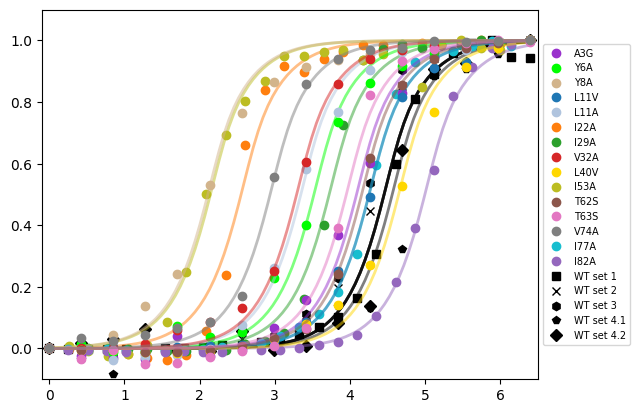

In [7]:
#List of mutants as desired order in the plot
mutant_list = ['A3G','Y6A','Y8A','L11V','L11A','I22A','I29A','V32A','L40V','I53A','T62S','T63S','V74A',"I77A","I82A","WT set 1",'WT set 2','WT set 3','WT set 4.1','WT set 4.2']
#List of markers as desired order in the plot
marker_list = ["o","o","o","o","o","o",'o','o','o',"o",'o',"o","o","o","o","s",'x',"h",'p','D']
#List of colors as desired order in the plot
color_list = ['darkorchid','lime','tan','tab:blue','lightsteelblue','tab:orange','tab:green','tab:red','gold','tab:olive','tab:brown','tab:pink','tab:gray','tab:cyan','tab:purple','k','k','k','k','k']

#Define x-space for the plotted fit:
fit_x = np.linspace(0,6.4,100)

#Labels in the order of the data in 'f_full':
mutants_label = ["I22A","I29A","I53A","I77A","I82A","WT set 1",'A3G','Y6A','Y8A','L11V','L11A','V32A','L40V','T62S','T63S','V74A','WT set 3','WT set 2','WT set 4.1','WT set 4.2']

#Plot: z-order is set such that WT samples are put behind mutant data:
for j,i in enumerate(mutants_label):
    if 'WT' in i:
        z_order = 1
    else: 
        z_order = 2
    index = mutant_list.index(i)
    if len(f[j]) == 24:
        plt.plot(x1,f[j],marker = marker_list[index],color = color_list[index], linewidth = 0, label = i, zorder = z_order)
    if len(f[j]) == 26:
        plt.plot(x2,f[j],marker = marker_list[index],color = color_list[index], linewidth = 0, label = i, zorder = z_order)
    if len(f[j]) == 16:
        plt.plot(x3,f[j],marker = marker_list[index],color = color_list[index], linewidth = 0, label = i, zorder = z_order)
    plt.plot(fit_x,fun_frac(result.params,(j),fit_x,c_range[j]/1000000,n_size),color = color_list[index],alpha=0.5,linewidth = 2, zorder = z_order)

plt.xlim(-0.1,6.5)
plt.ylim(-0.1,1.1)

handles, labels = plt.gca().get_legend_handles_labels()

plt.legend([handles[mutants_label.index(i)] for i in mutant_list],[labels[mutants_label.index(i)] for i in mutant_list],prop={'size': 7}, frameon = "False",loc='center left', bbox_to_anchor=(1, 0.5)) 